In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
from tqdm import tqdm
import xgboost as xgb
import tensorflow as tf
from keras.applications.resnet50 import ResNet50
# from keras.applications.resnet18 import ResNet18
from keras.models import Model
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import Flatten, Input
import scipy
from sklearn.metrics import fbeta_score
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import xgboost

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import keras
from tqdm import tqdm
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input
from keras.models import Model,Sequential,  load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
#from keras.optimizers import adam_v2
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications.vgg16 import VGG16

In [54]:
disease_types=['Apple___Apple_scab','Apple___Black_rot', 'Apple___Cedar_apple_rust','Apple___healthy',
               'Grape___healthy', 'Grape___Leaf_blight', 'Grape___Esca', 'Grape___Black_rot',
               'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight']

data_dir = '/content/drive/MyDrive/BitkiHastaligiTeshisi - OzgeOzaras/Mini_SqueezeNet_New/Kodlar/dataset'
train_dir = os.path.join(data_dir)

train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])

train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])

SEED = 42
train = train.sample(frac=1, random_state=SEED)
train.index = np.arange(len(train)) # Reset indices

In [55]:
IMAGE_SIZE = 224
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [56]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

9385it [01:02, 149.39it/s]


Train Shape: (9385, 224, 224, 3)


In [57]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train)

In [58]:
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

In [42]:
EPOCHS = 50
BATCH_SIZE=64
SIZE=224
N_ch=3

In [10]:
from keras.applications import ResNet50
def build_resnet50():
    resnet = ResNet50(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    x = resnet(x)
    x = Flatten(name="flatten")(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    # multi output
    output = Dense(11,activation = 'softmax', name='root')(x)
    # model
    model = Model(input,output)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()

    return model

In [11]:
model_ResNet50 = build_resnet50()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 3)         │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ root (Dense)                         │ (None, 11)                  │           2,827 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,282,015 (188.00 MB)

 Trainable params: 49,228,383 (187.79 MB)

 Non-trainable params: 53,632 (209.50 KB)

In [12]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

# Update filepath to use .keras extension
mc = ModelCheckpoint('best_model.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# You can now fit your model and include these callbacks
# Example:
# model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100, callbacks=[es, mc])


In [13]:
hist=model_ResNet50.fit(X_train, Y_train,
               batch_size=BATCH_SIZE,
               epochs=EPOCHS,
               verbose=1,
               validation_data=(X_val, Y_val),
               callbacks=[es,mc])

Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.7745 - loss: 0.7837
Epoch 1: val_accuracy improved from -inf to 0.02770, saving model to best_model.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 111s 415ms/step - accuracy: 0.7756 - loss: 0.7797 - val_accuracy: 0.0277 - val_loss: 7.8588
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9919 - loss: 0.0319
Epoch 2: val_accuracy improved from 0.02770 to 0.06287, saving model to best_model.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 14s 120ms/step - accuracy: 0.9919 - loss: 0.0319 - val_accuracy: 0.0629 - val_loss: 9.2981
Epoch 3/50
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9961 - loss: 0.0120
Epoch 3: val_accuracy did not improve from 0.06287
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - accuracy: 0.9961 - loss: 0.0119 - val_accuracy: 0.0629 - val_loss: 9.2142
Epoch 4/50
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9996 - loss: 0.0045
Epoch 4: val_accuracy did not improve from 0.06287
118/118 ━━━━━━

In [14]:
from tensorflow.keras.models import load_model

# Load the saved model using the correct file extension
saved_model = load_model('best_model.keras')

In [15]:
y_pred = saved_model.predict(X_val)

59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step


In [16]:
y_pred=np.argmax(y_pred, axis=1)

In [17]:
Y_val=np.argmax(Y_val, axis=1)

In [18]:
print("Doğruluk: ",accuracy_score(Y_val, y_pred))
print("F1_Skor: ", f1_score(Y_val, y_pred,average="macro"))
print("Hassasiyet: ",precision_score(Y_val, y_pred,average="macro"))
print("Duyarlılık: ", recall_score(Y_val, y_pred,average="macro"))

Doğruluk:  0.9994672349493873
F1_Skor:  0.9996413619333634
Hassasiyet:  0.9996448863636364
Duyarlılık:  0.9996392496392498


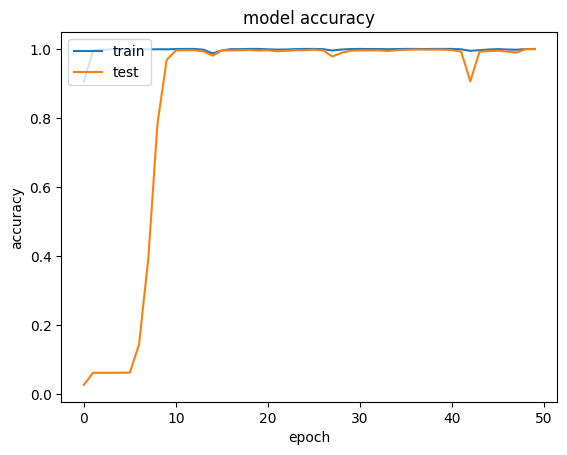

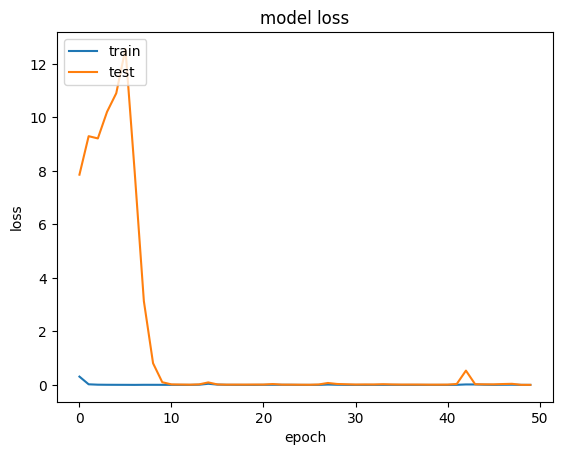

In [19]:

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[[112   1   0   3   0   0   0   0   0   0   2]
 [  0 128   0   0   1   0   0   0   0   0   0]
 [  0   0  52   0   0   0   0   0   0   0   0]
 [  2   0   0 360   0   0   0   0   0   0   0]
 [  0   0   0   1  76   0   0   0   0   0   0]
 [  1   0   0   0   0 208   0   5   0   0   0]
 [  0   0   0   0   0   0 241  13   1   0   0]
 [  0   0   0   1   0   0   1 249   0   0   1]
 [  0   0   0   1   0   2   0   1 176   0   2]
 [  0   0   0   0   0   0   0   0   0  23   7]
 [  3   0   0   0   0   0   0   0   0   0 203]]


<Axes: >

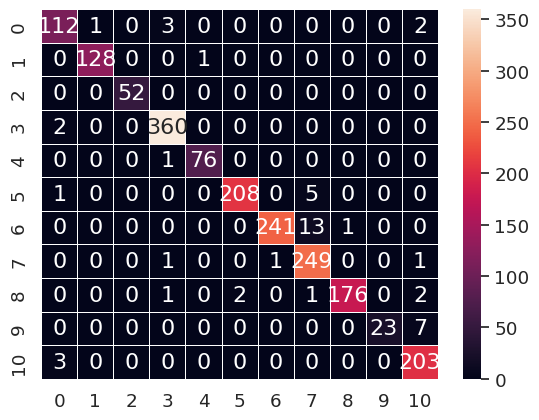

In [ ]:
import seaborn as sn
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(Y_val, y_pred)
print(cm)
sn.set(font_scale=1.2)#for label size
sn.heatmap(cm, annot=True,fmt="d", linewidths=.5 ,annot_kws={"size": 16})# font size

##  MobilNetV2

In [59]:
EPOCHS = 100
BATCH_SIZE=64
SIZE=224
N_ch=3

In [60]:
from keras.applications import MobileNetV2
def build_MobilNetV2():
    mobilnetv2 = MobileNetV2(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    x = mobilnetv2(x)
    x = Flatten(name="flatten")(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    # multi output
    output = Dense(11,activation = 'softmax', name='root')(x)
    # model
    model = Model(input,output)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()

    return model

In [61]:
model_mobilnet=build_MobilNetV2()

<ipython-input-60-319af5b0896c>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilnetv2 = MobileNetV2(weights='imagenet', include_top=False)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 224, 224, 3)         │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │      16,056,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ root (Dense)                         │ (None, 11)                  │           2,827 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,318,495 (69.88 MB)

 Trainable params: 18,283,871 (69.75 MB)

 Non-trainable params: 34,624 (135.25 KB)

In [62]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

# Update filepath to use .keras extension
mc = ModelCheckpoint('best_model.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# You can now fit your model and include these callbacks
# Example:
# model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100, callbacks=[es, mc])


In [63]:
hist=model_mobilnet.fit(X_train, Y_train,
               batch_size=BATCH_SIZE,
               epochs=EPOCHS,
               verbose=1,
               validation_data=(X_val, Y_val),
               callbacks=[es,mc])

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.6541 - loss: 1.1604
Epoch 1: val_accuracy improved from -inf to 0.62706, saving model to best_model.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 72s 262ms/step - accuracy: 0.6554 - loss: 1.1554 - val_accuracy: 0.6271 - val_loss: 1.8408
Epoch 2/100
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9761 - loss: 0.0729
Epoch 2: val_accuracy improved from 0.62706 to 0.67555, saving model to best_model.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.9761 - loss: 0.0729 - val_accuracy: 0.6755 - val_loss: 1.6098
Epoch 3/100
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9874 - loss: 0.0423
Epoch 3: val_accuracy improved from 0.67555 to 0.72563, saving model to best_model.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.9874 - loss: 0.0421 - val_accuracy: 0.7256 - val_loss: 1.3710
Epoch 4/100
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9918 - loss: 0.0278
Epoch 4: val_accuracy impro

In [64]:
from tensorflow.keras.models import load_model

# Load the saved model using the correct file extension
saved_model = load_model('best_model.keras')

In [65]:
y_pred = saved_model.predict(X_val)

59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step


In [66]:
y_pred=np.argmax(y_pred, axis=1)

In [67]:
Y_val=np.argmax(Y_val, axis=1)

In [68]:
print("Doğruluk: ",accuracy_score(Y_val, y_pred))
print("F1_Skor: ", f1_score(Y_val, y_pred,average="macro"))
print("Hassasiyet: ",precision_score(Y_val, y_pred,average="macro"))
print("Duyarlılık: ", recall_score(Y_val, y_pred,average="macro"))

Doğruluk:  0.9984017048481619
F1_Skor:  0.99735601082985
Hassasiyet:  0.9962710287774393
Duyarlılık:  0.9984932217377464


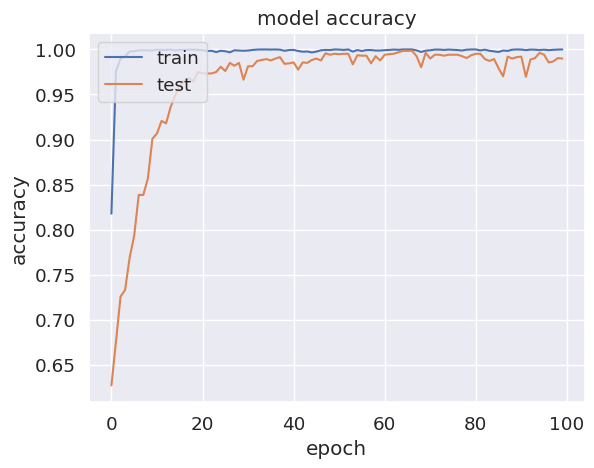

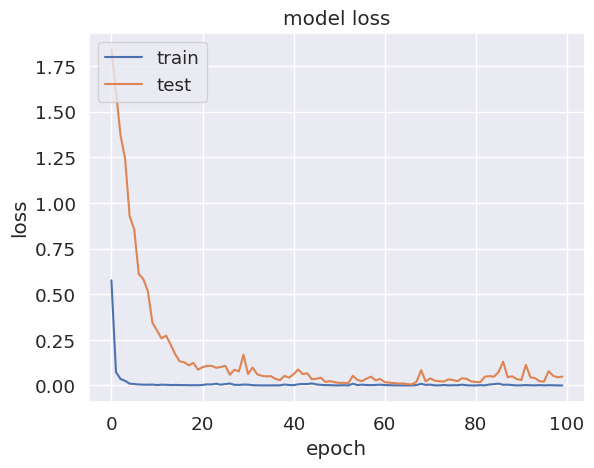

In [69]:

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[[118   0   0   0   0   0   0   0   0   0   0]
 [  0 128   0   0   0   0   0   0   0   0   1]
 [  0   0  52   0   0   0   0   0   0   0   0]
 [  0   0   0 362   0   0   0   0   0   0   0]
 [  0   0   0   0  77   0   0   0   0   0   0]
 [  0   0   0   0   0 214   0   0   0   0   0]
 [  0   0   0   0   0   0 255   0   0   0   0]
 [  0   0   0   0   0   0   1 251   0   0   0]
 [  0   0   0   0   0   0   0   0 182   0   0]
 [  0   0   0   0   0   0   0   0   0  30   0]
 [  0   0   0   0   0   0   0   0   0   1 205]]


<Axes: >

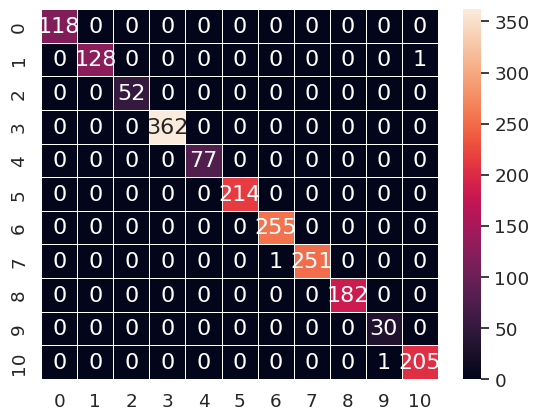

In [70]:
import seaborn as sn
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(Y_val, y_pred)
print(cm)
sn.set(font_scale=1.2)#for label size
sn.heatmap(cm, annot=True,fmt="d", linewidths=.5 ,annot_kws={"size": 16})# font size

## DenseNet121

In [43]:
from keras.applications.densenet import DenseNet121
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    x = densenet(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(11,activation = 'softmax', name='root')(x)

    # model
    model = Model(input,output)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()

    return model

In [44]:
model_dense = build_densenet()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 224, 224, 3)         │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ root (Dense)                         │ (None, 11)                  │           2,827 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,307,935 (27.88 MB)

 Trainable params: 7,221,727 (27.55 MB)

 Non-trainable params: 86,208 (336.75 KB)

In [45]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

# Update filepath to use .keras extension
mc = ModelCheckpoint('best_model.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# You can now fit your model and include these callbacks
# Example:
# model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100, callbacks=[es, mc])


In [46]:
hist= model_dense.fit(X_train, Y_train,
               batch_size=BATCH_SIZE,
               epochs=EPOCHS,
               verbose=1,
               validation_data=(X_val, Y_val),
               callbacks=[es,mc])

Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 947ms/step - accuracy: 0.5126 - loss: 1.6753
Epoch 1: val_accuracy improved from -inf to 0.34044, saving model to best_model.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 293s 1s/step - accuracy: 0.5143 - loss: 1.6688 - val_accuracy: 0.3404 - val_loss: 2.6279
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9406 - loss: 0.1876
Epoch 2: val_accuracy improved from 0.34044 to 0.76505, saving model to best_model.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 0.9407 - loss: 0.1873 - val_accuracy: 0.7651 - val_loss: 0.7995
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9784 - loss: 0.0730
Epoch 3: val_accuracy improved from 0.76505 to 0.92808, saving model to best_model.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 0.9784 - loss: 0.0730 - val_accuracy: 0.9281 - val_loss: 0.2569
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9881 - loss: 0.0436
Epoch 4: val_accuracy impr

In [47]:
from tensorflow.keras.models import load_model

# Load the saved model using the correct file extension
saved_model = load_model('best_model.keras')

In [48]:
y_pred = saved_model.predict(X_val)

59/59 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step


In [49]:
y_pred=np.argmax(y_pred, axis=1)

In [50]:
Y_val=np.argmax(Y_val, axis=1)

In [51]:
print("Doğruluk: ",accuracy_score(Y_val, y_pred))
print("F1_Skor: ", f1_score(Y_val, y_pred,average="macro"))
print("Hassasiyet: ",precision_score(Y_val, y_pred,average="macro"))
print("Duyarlılık: ", recall_score(Y_val, y_pred,average="macro"))

Doğruluk:  1.0
F1_Skor:  1.0
Hassasiyet:  1.0
Duyarlılık:  1.0


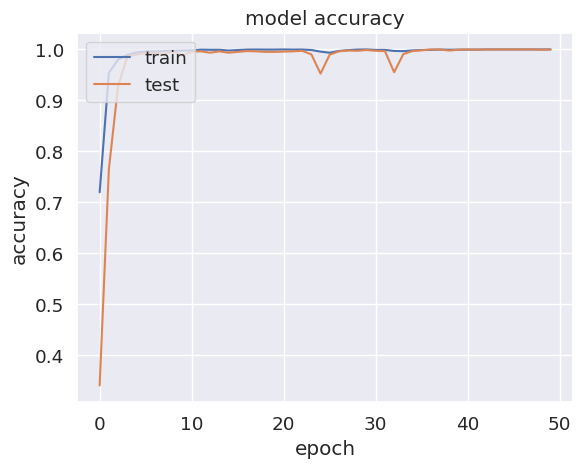

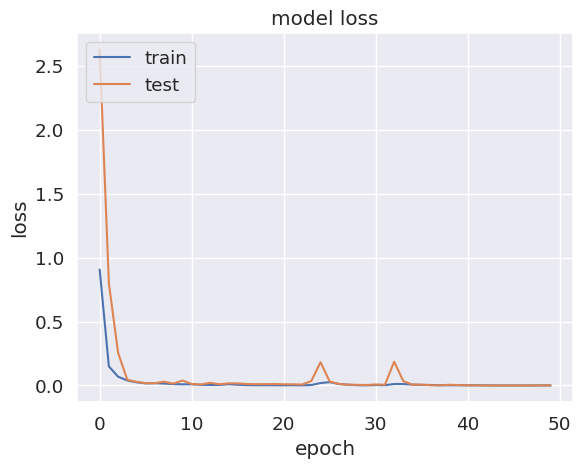

In [52]:

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[[118   0   0   0   0   0   0   0   0   0   0]
 [  0 129   0   0   0   0   0   0   0   0   0]
 [  0   0  52   0   0   0   0   0   0   0   0]
 [  0   0   0 362   0   0   0   0   0   0   0]
 [  0   0   0   0  77   0   0   0   0   0   0]
 [  0   0   0   0   0 214   0   0   0   0   0]
 [  0   0   0   0   0   0 255   0   0   0   0]
 [  0   0   0   0   0   0   0 252   0   0   0]
 [  0   0   0   0   0   0   0   0 182   0   0]
 [  0   0   0   0   0   0   0   0   0  30   0]
 [  0   0   0   0   0   0   0   0   0   0 206]]


<Axes: >

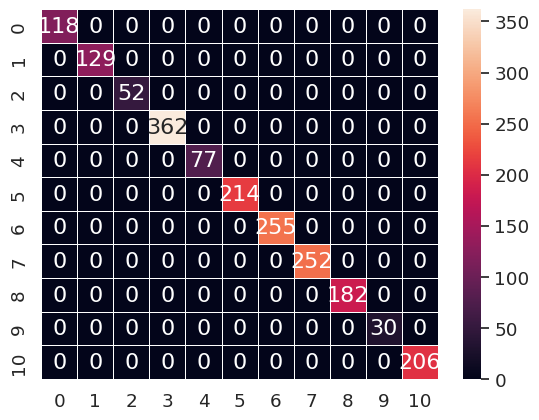

In [53]:
import seaborn as sn
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(Y_val, y_pred)
print(cm)
sn.set(font_scale=1.2)#for label size
sn.heatmap(cm, annot=True,fmt="d", linewidths=.5 ,annot_kws={"size": 16})# font size